In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np

import datetime
import matplotlib.dates as mdates

sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = [15, 10]

# Key business questions

What game licenses should I buy next?
1. Which are the paid games with the highest/lowest `total_revenue` and `ratings`.
    - What genres are the most popular?
2. Does the identity of the developer matter for choosing the next game license I should buy?
    - Connect developers to genre. Check popular developers in each genre.
    - Look into the track record/portfolio of games of the notable developers.
        - filter in rows containing `genre`.
    - Value of answering question: it will allow Valve to antipicate upcoming games of certain developers.
3. What is the optimal price range of a game (by genre by owner group) that Steam should prioritize?

## Question dump

<s>
**As Valve**
1. What should a company make for their next game?
2. Compare free to play games and paid games in terms of `total_revenue` and `ratings` 

    Definitions:
    \begin{align}
    \text{total revenue} &= \text{midpoint of owners} \times \text{price}
    \end{align}
    
    \begin{align}
    \text{ratings} &= \frac{\text{positive ratings}}{\text{total ratings}} \times 100
    \end{align}
    
    Let's use $\geq 80\%$ as high score?
3. What are the kind of paid games with lowest `total_revenue` and `ratings`?
4. What gaming companies do gamers prefer?
    - Which companies have a lot of successful games? (look at revenue, ratings, genre, owners)
5. <s>Multiplayer servers that they can shut down (to reduce costs).</s>

---
**As an avid Steam gamer**
1. What gaming genres should a gamer try out?
2. What gaming companies should a gamer look out for?
    - Which companies have a lot of successful games? (look at revenue, ratings, genre, owners)
2. What games have a high `total_revenue`, `ratings`, and is owned by at least $10$ million gamers?
3. Analyze the `average_playtime` by `year` (create a trend line).

---
**As a parent of a Steam gamer**
1. Are we assured that games for 3 to 16 years old and games with no `restricted_age` are child-friendly?
    Definitions:
    Child-friendly - Games with no violence, gore, nudity or sexual content

    To do:
    Look for violent, gore, nudity or sexual content `genres` for games that have no `restricted_age` and
    games for 3 to 16 years old.

    We can also check in `steamspy_tags` but it has 339 tags.

2. What is the average `price` of games for 3 to 16 years old and games with no `required_age` and are also child-friendly?

3. What are some educational (`education` in `genres`) games for 3 to 16 years old and games with no age restrictions?</s>


# Understanding the data

## Loading the dataframe

In [2]:
steam_df = pd.read_csv('steam.csv')
steam_df = steam_df[(~steam_df['developer'].str.contains('Valve')) | steam_df['developer'].str.contains('Valverde')]
steam_df = steam_df[steam_df['english'] == True]
steam_df = steam_df.drop(columns='english').reset_index(drop=True)
steam_df

,appid,name,release_date,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,50,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99
1,130,Half-Life: Blue Shift,2001-06-01,Gearbox Software,Valve,windows;mac;linux,0,Single-player,Action,FPS;Action;Sci-fi,0,3822,420,361,205,5000000-10000000,3.99
2,1002,Rag Doll Kung Fu,2005-10-12,Mark Healey,Mark Healey,windows,0,Single-player;Multi-player,Indie,Indie;Fighting;Multiplayer,0,40,17,0,0,20000-50000,5.99
3,1200,Red Orchestra: Ostfront 41-45,2006-03-14,Tripwire Interactive,Tripwire Interactive,windows;mac;linux,0,Multi-player;Steam Achievements;Valve Anti-Che...,Action,World War II;Action;FPS,44,1562,223,232,258,500000-1000000,3.99
4,1250,Killing Floor,2009-05-14,Tripwire Interactive,Tripwire Interactive,windows;mac;linux,0,Single-player;Multi-player;Co-op;Cross-Platfor...,Action,FPS;Zombies;Co-op,285,53710,2649,1328,306,2000000-5000000,14.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26531,1065230,Room of Pandora,2019-04-24,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,Adventure;Indie;Casual,7,3,0,0,0,0-20000,2.09
26532,1065570,Cyber Gun,2019-04-23,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Adventure;Indie,Action;Indie;Adventure,0,8,1,0,0,0-20000,1.69
26533,1065650,Super Star Blast,2019-04-24,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,Action;Indie;Casual,24,0,1,0,0,0-20000,3.99
26534,1066700,New Yankee 7: Deer Hunters,2019-04-17,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure,0,2,0,0,0,0-20000,5.19


## Checking for missing data

In [3]:
steam_df.isna().sum()

appid               0
name                0
release_date        0
developer           0
publisher           0
platforms           0
required_age        0
categories          0
genres              0
steamspy_tags       0
achievements        0
positive_ratings    0
negative_ratings    0
average_playtime    0
median_playtime     0
owners              0
price               0
dtype: int64

In [4]:
steam_df.dtypes

appid                 int64
name                 object
release_date         object
developer            object
publisher            object
platforms            object
required_age          int64
categories           object
genres               object
steamspy_tags        object
achievements          int64
positive_ratings      int64
negative_ratings      int64
average_playtime      int64
median_playtime       int64
owners               object
price               float64
dtype: object

### Check for duplicated game `name`s

In [5]:
steam_df[steam_df['name'].duplicated()]

,appid,name,release_date,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
4635,345130,Dark Matter,2015-02-27,Meridian4,Meridian4,windows,0,Single-player;Partial Controller Support,Action;Casual;Indie,Action;Casual;Indie,0,75,50,0,0,100000-200000,3.99
7862,436260,Ultimate Arena,2016-09-05,Kenneth Caselli;Gianmarco Rocco,AceGamer Network,windows;linux,0,Multi-player;Online Multi-Player;Steam Achieve...,Action;Indie,Action;Indie;FPS,1,123,100,0,0,0-20000,13.99
8176,446480,New York Bus Simulator,2016-03-04,Little Freedom Factory,United Independent Entertainment GmbH,windows,0,Single-player,Simulation,Simulation,0,7,42,0,0,0-20000,3.99
9416,488080,Taxi,2016-10-07,petraguardsoftware.com,petraguardsoftware.com,windows,0,Single-player;Steam Achievements;Steam Cloud,Casual,Casual,11,1,1,0,0,0-20000,1.59
10279,510850,Mars 2030,2017-07-31,FMG Labs,Fusion Media Group,windows,0,Single-player;Steam Achievements;Full controll...,Simulation,Simulation;Mars;Space,10,40,22,0,0,0-20000,10.99
11373,542220,Rumpus,2017-04-12,Polyraptor Games,Polyraptor Games,windows;mac;linux,0,Single-player;Local Multi-Player;Local Co-op;S...,Action;Casual;Indie,Action;Indie;Casual,19,23,0,0,0,0-20000,9.99
14183,622810,Invasion,2018-06-15,brutalsoft,brutalsoft,windows,0,Single-player;Steam Achievements;Steam Cloud,Action;Indie,Action;Indie;Arcade,19,24,1,0,0,0-20000,3.99
15407,664780,Alter Ego,2017-08-08,Choose Multiple LLC,Choose Multiple LLC,windows;mac;linux,0,Single-player;Captions available;Steam Cloud,Adventure;Casual;Indie;RPG;Simulation,RPG;Casual;Simulation,0,17,8,0,0,0-20000,5.59
15480,666660,Castles,2017-07-14,Quicksilver Software,interplay,windows;mac,0,Single-player,Adventure;Strategy,Strategy;Adventure,0,2,3,0,0,0-20000,6.99
15485,666810,Luna,2017-08-15,Lushboy Studios,Lushboy Studios,windows;mac,0,Single-player;Partial Controller Support,Action;Indie,Action;Indie;Puzzle-Platformer,19,10,0,0,0,0-20000,0.79


## Cleaning data

### Games whose `name`, `developer`, or `publisher` contain non-ASCII characters.

In [6]:
steam_df[~(steam_df['name'].map(str.isascii) & 
          steam_df['developer'].map(str.isascii) & 
          steam_df['publisher'].map(str.isascii))]['name']

37          Gumboy - Crazy Adventures™
40                                GUN™
41                       Call of Duty®
42                     Call of Duty® 2
56                          FlatOut 2™
                     ...              
26479            10-4 Indirect Contact
26499     Twinkle Star - 未来はすぐそこで待っている
26504     胜利即正义! / Victory is justice！
26507    The Underground Watcher/地下监察员
26522                   Blacksmith Run
Name: name, Length: 1628, dtype: object

### Converting `release_date` to `datetime`

In [7]:
steam_df['release_date'] = pd.to_datetime(steam_df['release_date'])
steam_df['release_date'].dtype

dtype('<M8[ns]')

### Checking the binning of `owners`

In [8]:
pd.Series(steam_df['owners'].unique())

0       5000000-10000000
1            20000-50000
2         500000-1000000
3        2000000-5000000
4          100000-200000
5           50000-100000
6        1000000-2000000
7          200000-500000
8      10000000-20000000
9                0-20000
10     20000000-50000000
11    50000000-100000000
dtype: object

### Taking the floor `owners`

In [9]:
floor_owners = np.array([10_000_000, 5_000_000, 2_000_000, 20_000_000, 
                         100_000_000, 50_000_000, 20_000, 500_000, 100_000, 
                         50_000, 1_000_000, 200_000, 0])

floor_owner_dict = dict(zip(steam_df['owners'].unique(), floor_owners))
floor_owner_dict

{'5000000-10000000': 10000000,
 '20000-50000': 5000000,
 '500000-1000000': 2000000,
 '2000000-5000000': 20000000,
 '100000-200000': 100000000,
 '50000-100000': 50000000,
 '1000000-2000000': 20000,
 '200000-500000': 500000,
 '10000000-20000000': 100000,
 '0-20000': 50000,
 '20000000-50000000': 1000000,
 '50000000-100000000': 200000}

In [10]:
ave_owners = np.array([15_000_000, 7_500_000, 3_500_000, 35_000_000, 
                       150_000_000, 75_000_000, 35_000, 750_000, 150_000, 
                       75_000, 1_500_000, 350_000, 10_000])

ave_owner_dict = dict(zip(steam_df['owners'].unique(), ave_owners))
ave_owner_dict

{'5000000-10000000': 15000000,
 '20000-50000': 7500000,
 '500000-1000000': 3500000,
 '2000000-5000000': 35000000,
 '100000-200000': 150000000,
 '50000-100000': 75000000,
 '1000000-2000000': 35000,
 '200000-500000': 750000,
 '10000000-20000000': 150000,
 '0-20000': 75000,
 '20000000-50000000': 1500000,
 '50000000-100000000': 350000}

In [11]:
steam_df = steam_df.replace({'owners': ave_owner_dict})

## Statistics

In [12]:
steam_df.drop(columns=['appid']).describe()

,required_age,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
count,26536.000000,26536.000000,26536.000000,26536.000000,26536.000000,26536.000000,2.653600e+04,26536.000000
mean,0.356233,45.939215,832.027095,190.709527,146.438951,144.567908,1.377621e+07,6.088543
std,2.409387,356.167752,7889.472542,3438.610713,1809.516050,2335.418746,3.668024e+07,7.880293
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.500000e+04,0.000000
25%,0.000000,0.000000,6.000000,2.000000,0.000000,0.000000,7.500000e+04,1.690000
50%,0.000000,7.000000,25.000000,9.000000,0.000000,0.000000,7.500000e+04,3.990000
75%,0.000000,23.000000,126.000000,42.000000,0.000000,0.000000,3.500000e+06,7.190000
max,18.000000,9821.000000,496184.000000,487076.000000,190625.000000,190625.000000,1.500000e+08,421.990000


# Feature engineering

In [13]:
# New dataframe to store new features (mergable by `name`)
extra_df = steam_df['appid'].to_frame()
extra_df

,appid
0,50
1,130
2,1002
3,1200
4,1250
...,...
26531,1065230
26532,1065570
26533,1065650
26534,1066700


## `price_range`
---
**Outlier treatment proposition.**

Games priced above $50$ GBP are outliers. Only a few gamers can afford such high prices.

In [14]:
# 1 GBP to PHP conversion for potential analysis
GBP_to_PHP = 65.37

# Custom binning to categorize price range
price_binning = np.linspace(0, 422, 20)
price_binning = np.array([-0.1, 0.31, 40, 50, 100, 422])

extra_df['price_range'] = pd.cut(steam_df['price'], price_binning)
extra_df

,appid,price_range
0,50,"(0.31, 40.0]"
1,130,"(0.31, 40.0]"
2,1002,"(0.31, 40.0]"
3,1200,"(0.31, 40.0]"
4,1250,"(0.31, 40.0]"
...,...,...
26531,1065230,"(0.31, 40.0]"
26532,1065570,"(0.31, 40.0]"
26533,1065650,"(0.31, 40.0]"
26534,1066700,"(0.31, 40.0]"


## `release_year`

In [15]:
extra_df['release_year'] = steam_df['release_date'].dt.year
extra_df

,appid,price_range,release_year
0,50,"(0.31, 40.0]",1999
1,130,"(0.31, 40.0]",2001
2,1002,"(0.31, 40.0]",2005
3,1200,"(0.31, 40.0]",2006
4,1250,"(0.31, 40.0]",2009
...,...,...,...
26531,1065230,"(0.31, 40.0]",2019
26532,1065570,"(0.31, 40.0]",2019
26533,1065650,"(0.31, 40.0]",2019
26534,1066700,"(0.31, 40.0]",2019


## `total_ratings`
---
**Outlier treatment proposition.**

Set a lower bound within the range of `total_ratings` values to check only relevant games.

In [16]:
extra_df['total_ratings'] = (steam_df['positive_ratings'] 
                            + steam_df['negative_ratings'])
extra_df

,appid,price_range,release_year,total_ratings
0,50,"(0.31, 40.0]",1999,5538
1,130,"(0.31, 40.0]",2001,4242
2,1002,"(0.31, 40.0]",2005,57
3,1200,"(0.31, 40.0]",2006,1785
4,1250,"(0.31, 40.0]",2009,56359
...,...,...,...,...
26531,1065230,"(0.31, 40.0]",2019,3
26532,1065570,"(0.31, 40.0]",2019,9
26533,1065650,"(0.31, 40.0]",2019,1
26534,1066700,"(0.31, 40.0]",2019,2


## `score`
---
**Outlier treatment proposition.**

$100\%$ `ratings` are outliers. In reality, this only happens if a game is so unknown that nobody actually plays it.

**Note.**

Set a threshold for the `total_ratings` for `ratings` that are valid/reflective of the game's success/popularity.

Try: `sns.histplot`

In [17]:
extra_df['score'] = round(steam_df['positive_ratings']
                           /extra_df['total_ratings']*100, 2)
extra_df

,appid,price_range,release_year,total_ratings,score
0,50,"(0.31, 40.0]",1999,5538,94.80
1,130,"(0.31, 40.0]",2001,4242,90.10
2,1002,"(0.31, 40.0]",2005,57,70.18
3,1200,"(0.31, 40.0]",2006,1785,87.51
4,1250,"(0.31, 40.0]",2009,56359,95.30
...,...,...,...,...,...
26531,1065230,"(0.31, 40.0]",2019,3,100.00
26532,1065570,"(0.31, 40.0]",2019,9,88.89
26533,1065650,"(0.31, 40.0]",2019,1,0.00
26534,1066700,"(0.31, 40.0]",2019,2,100.00


## `total_revenue`
---
This is a proxy for total revenue data by multiplying the number of `owners` by the `price`.

**Note.**
- This is applicable only to paid games.
- Older games will naturally aggregate more total revenue through time.
- Players will almost always buy the game either on release or during Steam sales.

---
**Outlier treatment proposition.**

Set a lower bound within the range of `total_revenue` values to check only relevant games.

In [18]:
extra_df['total_revenue'] = steam_df['owners'] * steam_df['price']
extra_df

,appid,price_range,release_year,total_ratings,score,total_revenue
0,50,"(0.31, 40.0]",1999,5538,94.80,59850000.0
1,130,"(0.31, 40.0]",2001,4242,90.10,59850000.0
2,1002,"(0.31, 40.0]",2005,57,70.18,44925000.0
3,1200,"(0.31, 40.0]",2006,1785,87.51,13965000.0
4,1250,"(0.31, 40.0]",2009,56359,95.30,524650000.0
...,...,...,...,...,...,...
26531,1065230,"(0.31, 40.0]",2019,3,100.00,156750.0
26532,1065570,"(0.31, 40.0]",2019,9,88.89,126750.0
26533,1065650,"(0.31, 40.0]",2019,1,0.00,299250.0
26534,1066700,"(0.31, 40.0]",2019,2,100.00,389250.0


## Merge `steam_df` and `extra_df` by `app_id`

In [19]:
# main_df contains all existing and newly-engineered features.
main_df = steam_df.merge(extra_df, how='left')

main_df.to_csv('steam_for_tableau.csv', index=False)

# Univariate Analysis

## Counting values

### Number of games by `developer`

In [56]:
hist_dev = main_df['developer'].value_counts()[main_df['developer'].value_counts() >= 35]
hist_dev

Choice of Games             94
Ripknot Systems             62
Laush Dmitriy Sergeevich    51
Nikita "Ghost_RUS"          50
Dexion Games                45
RewindApp                   43
Hosted Games                42
Blender Games               40
Humongous Entertainment     36
For Kids                    36
EnsenaSoft                  35
Name: developer, dtype: int64

Insighting based on the complete data will be a hit or miss for developers with relatively few games released. So for actionable insights, treat them separately.

<AxesSubplot:>

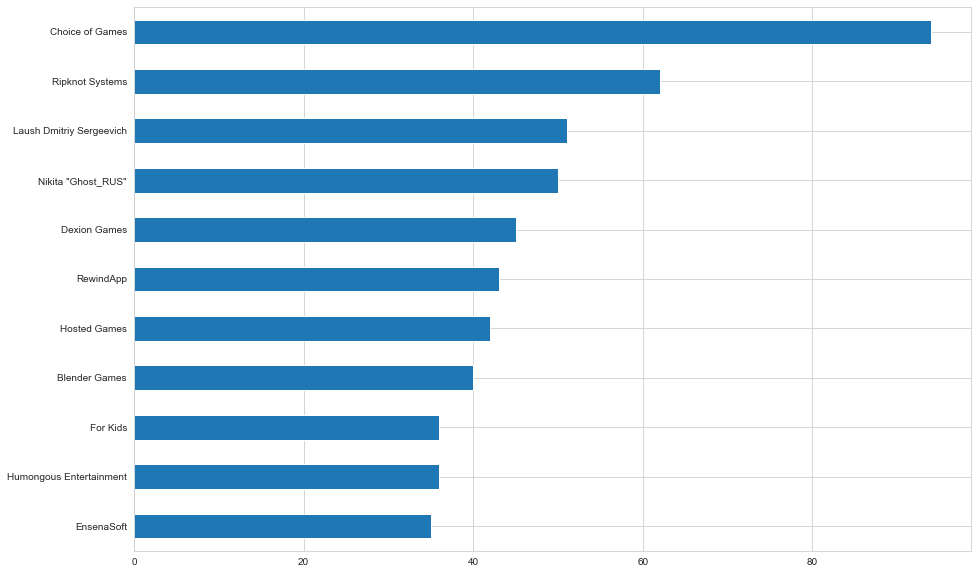

In [58]:
hist_dev.sort_values().plot(kind='barh')

<AxesSubplot:>

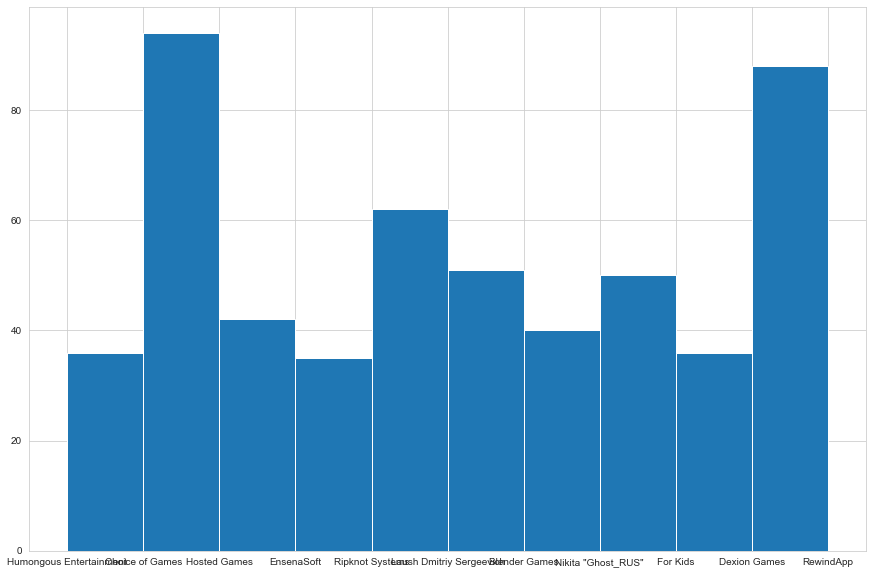

In [22]:
main_df[main_df['developer'].isin(hist_dev.index)]['developer'].hist()

### Number of games by `publisher`

In [69]:
hist_pub = main_df['publisher'].value_counts()[:14]
hist_pub

Big Fish Games         212
Strategy First         136
Ubisoft                111
THQ Nordic              98
Square Enix             97
Sekai Project           96
Choice of Games         94
1C Entertainment        88
Dagestan Technology     87
SEGA                    78
Degica                  72
Plug In Digital         72
KISS ltd                71
Slitherine Ltd.         71
Name: publisher, dtype: int64

<AxesSubplot:>

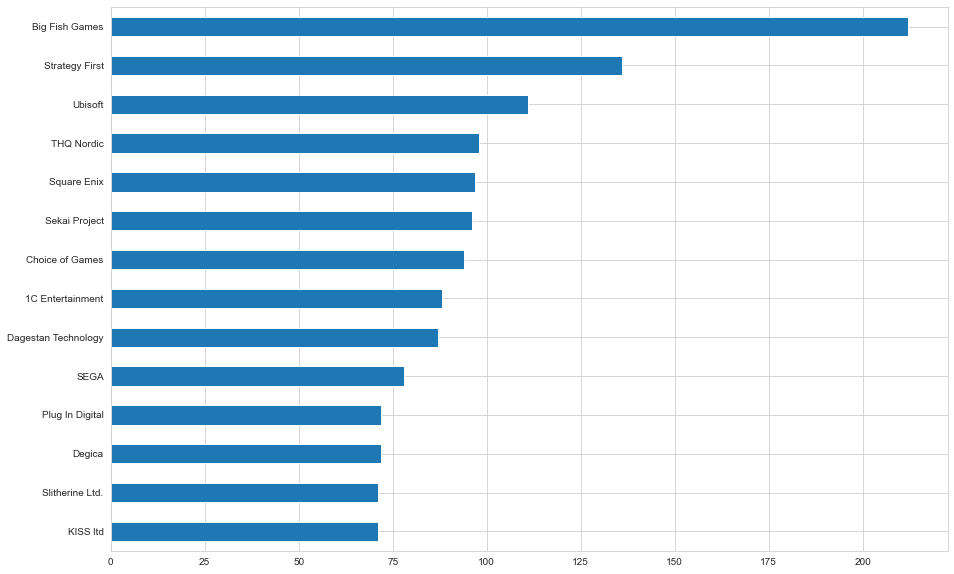

In [71]:
hist_pub.sort_values().plot(kind='barh')

### Number of games by `required_age`

**Look this up online.**
- Who sets the binning the binning of age restriction?
- **Answer.** Entertainment Software Rating Board. Check this [link](https://pegi.info/what-do-the-labels-mean).

In [24]:
main_df['required_age'].value_counts()

0     25949
18      300
16      192
12       72
7        12
3        11
Name: required_age, dtype: int64

<AxesSubplot:>

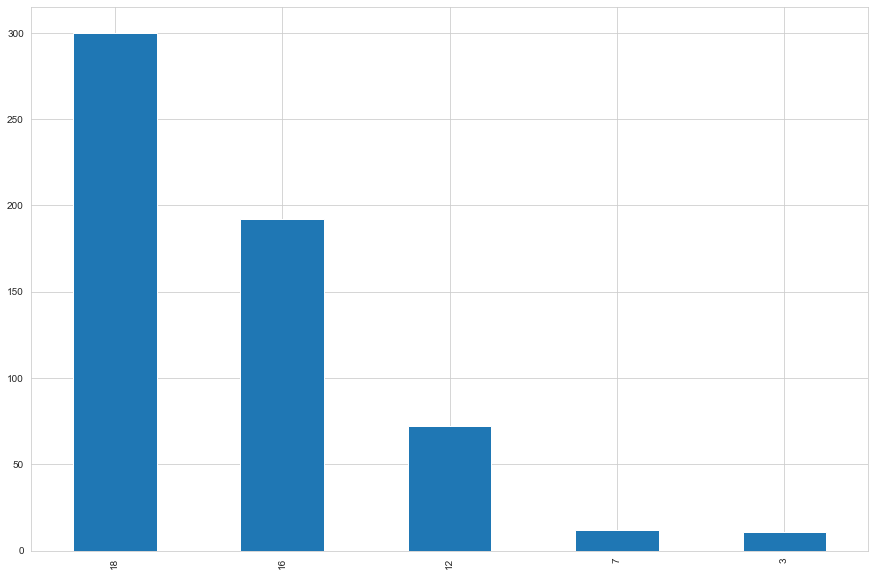

In [74]:
main_df['required_age'].value_counts()[1:].plot(kind='bar')

### Number of games by `owners`

In [76]:
hist_owner = main_df['owners'].value_counts()
hist_owner

75000        18166
7500000       3016
75000000      1676
150000000     1373
750000        1268
3500000        512
35000          285
35000000       190
15000000        35
150000          12
1500000          2
350000           1
Name: owners, dtype: int64

<AxesSubplot:>

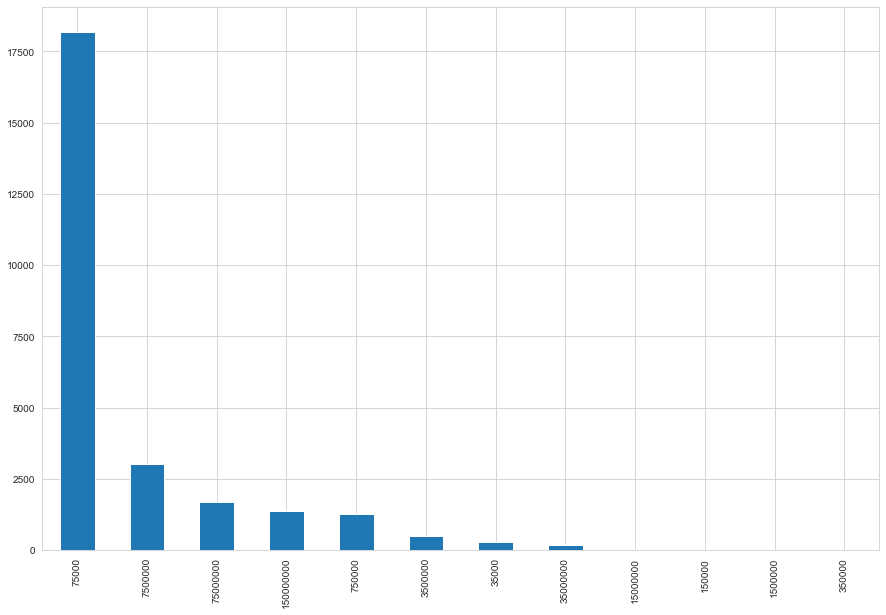

In [77]:
hist_owner.plot(kind='bar')

### Number of games by `platforms`

In [26]:
main_df['platforms'].value_counts()

windows              17934
windows;mac;linux     4584
windows;mac           3405
windows;linux          608
mac                      3
mac;linux                1
linux                    1
Name: platforms, dtype: int64

### Number of games by `achievements`

**Potential insights.**
- There are certain genres that are only popular if they have a lot of achievements. Look into bivariate analysis.

In [85]:
hist_achieve = main_df['achievements'].value_counts()[main_df['achievements'].value_counts() >= 17]
hist_achieve

0     11525
10      671
12      611
20      562
15      487
      ...  
71       18
85       18
81       17
99       17
82       17
Name: achievements, Length: 85, dtype: int64

<AxesSubplot:>

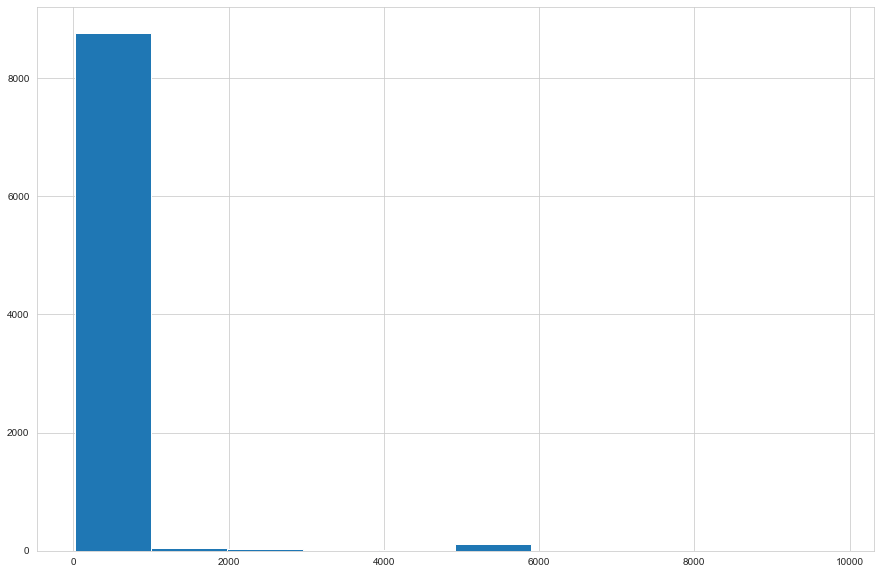

In [92]:
main_df[main_df['achievements'] >= 17]['achievements'].hist()

### Number of games by `categories`

Note that categories are not mutually exclusive. Therefore, the total count per category does not correspond to the total number of games, that is, some games may be counted in multiple categories.

#### Wrangling

In [28]:
# Find all unique categories
categories = np.array(list(set([cat for entry in main_df['categories']
                                .str.split(';').tolist() 
                                for cat in entry])))
pd.Series(categories)

0           SteamVR Collectibles
1                  Single-player
2          Includes level editor
3             Steam Achievements
4                            MMO
5            Steam Trading Cards
6                    Local Co-op
7            Includes Source SDK
8                          Stats
9               In-App Purchases
10                   Steam Cloud
11    Partial Controller Support
12      Steam Turn Notifications
13      Valve Anti-Cheat enabled
14            Steam Leaderboards
15            Captions available
16                Steam Workshop
17                  Online Co-op
18       Full controller support
19           Shared/Split Screen
20          Commentary available
21            Mods (require HL2)
22           Online Multi-Player
23            Local Multi-Player
24    Cross-Platform Multiplayer
25                  Multi-player
26                    VR Support
27                          Mods
28                         Co-op
dtype: object

#### Counting

In [29]:
# Number of games by unique combination of categories
cat_per_entry = main_df['categories'].value_counts()
cat_per_entry

Single-player                                                                                                                                            5910
Single-player;Steam Achievements                                                                                                                         2286
Single-player;Steam Achievements;Steam Trading Cards                                                                                                      843
Single-player;Partial Controller Support                                                                                                                  787
Single-player;Steam Trading Cards                                                                                                                         785
                                                                                                                                                         ... 
Single-player;Multi-player;Online Multi-Player;Steam

In [30]:
# Number of games by category
cat_counts = (pd.DataFrame((cat, cat_per_entry[cat_per_entry
                                              .index
                                              .str.contains(cat)]
                           .sum()) for cat in categories)
              .rename(columns={0:'categories', 1:'count'})
              .set_index('categories')
              .squeeze().sort_values(ascending=False))

cat_percent = cat_counts/main_df.shape[0]*100
cat_percent

C:\Users\Jam\AppData\Local\Temp/ipykernel_7960/420599164.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  cat_counts = (pd.DataFrame((cat, cat_per_entry[cat_per_entry


categories
Single-player                 94.905035
Steam Achievements            52.611547
Steam Trading Cards           29.635213
Steam Cloud                   26.590292
Full controller support       21.355894
Partial Controller Support    15.729575
Multi-player                  14.817606
Steam Leaderboards            12.922068
Co-op                          9.741483
Online Multi-Player            9.202593
Shared/Split Screen            8.083358
Stats                          7.016883
Local Multi-Player             6.052156
Cross-Platform Multiplayer     4.043563
Online Co-op                   4.005879
Local Co-op                    3.979500
Includes level editor          3.881519
Steam Workshop                 3.338860
Captions available             2.668074
In-App Purchases               2.509798
MMO                            1.518692
VR Support                     0.866747
Commentary available           0.497437
Valve Anti-Cheat enabled       0.293940
Steam Turn Notifications     

<AxesSubplot:ylabel='categories'>

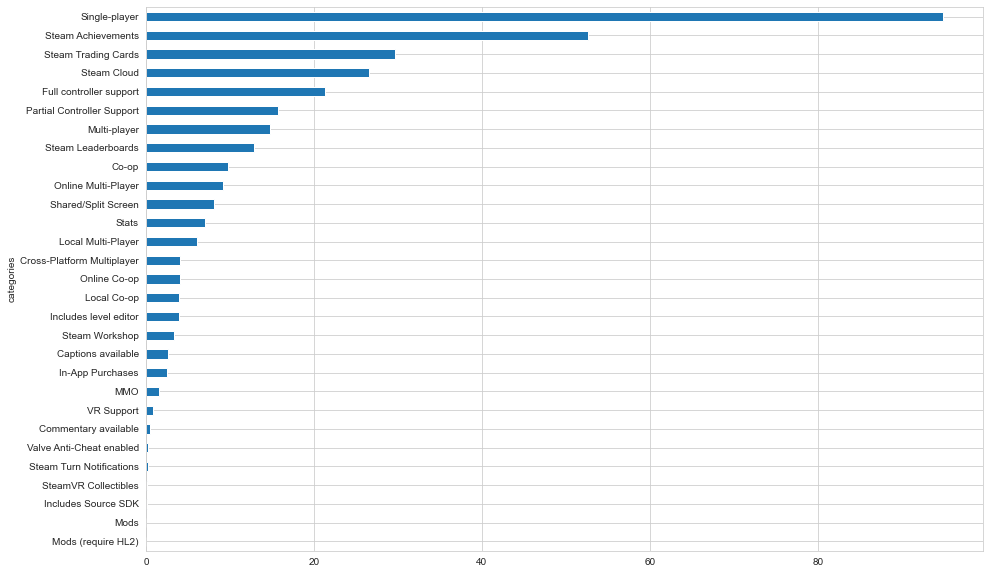

In [94]:
cat_percent.sort_values().plot(kind='barh')

### Number of games by `genres`

Note that genres are not mutually exclusive. Therefore, the total count per genre does not correspond to the total number of games, that is, some games may be counted in multiple genres.

#### Wrangling

In [31]:
genres = np.array(list(set([gen for entry in main_df['genres']
                                .str.split(';').tolist() 
                                for gen in entry])))
pd.Series(genres)

0     Massively Multiplayer
1                       RPG
2                    Racing
3            Web Publishing
4                    Action
5         Software Training
6                     Indie
7                Simulation
8            Sexual Content
9                    Nudity
10              Documentary
11                Adventure
12             Early Access
13         Game Development
14                  Violent
15                   Casual
16                   Sports
17                Education
18         Video Production
19     Animation & Modeling
20                Utilities
21         Audio Production
22               Accounting
23    Design & Illustration
24                 Strategy
25                     Gore
26                 Tutorial
27            Photo Editing
28             Free to Play
dtype: object

#### Counting

In [32]:
# Number of games by unique combination of genres
gen_per_entry = main_df['genres'].value_counts()
gen_per_entry

Action;Indie                                                                 1840
Casual;Indie                                                                 1467
Action;Adventure;Indie                                                       1223
Adventure;Indie                                                              1148
Action;Casual;Indie                                                          1000
                                                                             ... 
Casual;Free to Play;Massively Multiplayer;Early Access                          1
Nudity;Adventure;Casual                                                         1
Casual;Free to Play;Indie;Racing;Early Access                                   1
Casual;Indie;Massively Multiplayer;Simulation;Early Access                      1
Action;Adventure;Casual;Free to Play;Indie;RPG;Simulation;Sports;Strategy       1
Name: genres, Length: 1528, dtype: int64

In [33]:
# Number of games by genres
gen_counts = (pd.DataFrame((gen, gen_per_entry[gen_per_entry
                                              .index
                                              .str.contains(gen)]
                           .sum()) for gen in genres)
              .rename(columns={0:'genres', 1:'count'})
              .set_index('genres')
              .squeeze().sort_values(ascending=False))

gen_percent = gen_counts/main_df.shape[0]*100
gen_percent

genres
Indie                    71.947543
Action                   44.433976
Casual                   37.786403
Adventure                36.919656
Strategy                 19.222942
Simulation               19.158879
RPG                      15.390413
Early Access             10.875791
Free to Play              6.180283
Sports                    4.963069
Racing                    3.847603
Violent                   3.135363
Massively Multiplayer     2.626620
Gore                      1.997287
Nudity                    0.968496
Sexual Content            0.896895
Utilities                 0.542659
Design & Illustration     0.324088
Animation & Modeling      0.290172
Education                 0.188423
Video Production          0.135665
Software Training         0.113054
Audio Production          0.105517
Web Publishing            0.101749
Game Development          0.060295
Photo Editing             0.041453
Accounting                0.018842
Tutorial                  0.003768
Documentary  

<AxesSubplot:ylabel='genres'>

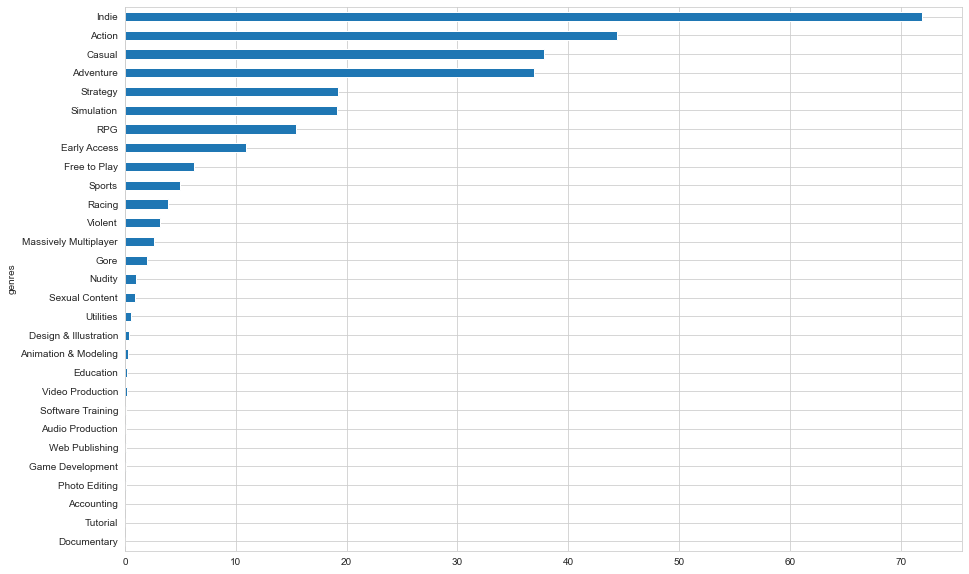

In [95]:
gen_percent.sort_values().plot(kind='barh')

### Number of games by `steamspy_tags`

Note that SteamSpy tags are not mutually exclusive. Therefore, the total count per SteamSpy tag does not correspond to the total number of games, that is, some games may be counted in multiple SteamSpy tags.

#### Wrangling

In [34]:
tags = np.array(list(set([tag for entry in main_df['steamspy_tags']
                                .str.split(';').tolist() 
                                for tag in entry])))
pd.Series(tags)

0                 Action
1      Turn-Based Combat
2                 Linear
3                   LEGO
4                 Nudity
             ...        
334              Physics
335          Bullet Time
336                Movie
337           Text-Based
338                1980s
Length: 339, dtype: object

#### Counting

In [35]:
# Number of games by unique combination of tags
tag_per_entry = main_df['steamspy_tags'].value_counts()
tag_per_entry

Action;Indie;Casual                      840
Action;Adventure;Indie                   711
Early Access;Action;Indie                502
Adventure;Indie;Casual                   430
Indie;Casual                             373
                                        ... 
Beat 'em up;Action;Arcade                  1
Action;Zombies;Adventure                   1
Racing;Destruction;Simulation              1
Strategy;RTS;Pixel Graphics                1
Early Access;Adventure;Sexual Content      1
Name: steamspy_tags, Length: 6339, dtype: int64

In [36]:
# Number of games by tags
tag_counts = (pd.DataFrame((tag, tag_per_entry[tag_per_entry
                                              .index
                                              .str.contains(tag)]
                           .sum()) for tag in tags)
              .rename(columns={0:'tags', 1:'count'})
              .set_index('tags')
              .squeeze().sort_values(ascending=False))

tag_percent = tag_counts/main_df.shape[0]*100
tag_percent

tags
Indie                             60.231384
Action                            38.615466
Casual                            30.434127
Adventure                         28.662948
Strategy                          15.318812
                                    ...    
Perma Death                        0.003768
Intentionally Awkward Controls     0.003768
Kickstarter                        0.003768
Parody                             0.003768
Diplomacy                          0.003768
Name: count, Length: 339, dtype: float64

#### Checking for overlapping values in `categories`, `genres`, and `steamspy_tags`

In [37]:
(np.intersect1d(categories, genres), 
 np.intersect1d(genres, tags), 
 np.intersect1d(tags, categories))

(array([], dtype='<U26'),
 array(['Action', 'Adventure', 'Animation & Modeling', 'Audio Production',
        'Casual', 'Design & Illustration', 'Documentary', 'Early Access',
        'Education', 'Free to Play', 'Game Development', 'Gore', 'Indie',
        'Massively Multiplayer', 'Nudity', 'Photo Editing', 'RPG',
        'Racing', 'Sexual Content', 'Simulation', 'Software Training',
        'Sports', 'Strategy', 'Utilities', 'Video Production', 'Violent',
        'Web Publishing'], dtype='<U33'),
 array(['Co-op'], dtype='<U33'))

**Proposition.**

We can neglect the tags that overlap with genres and categories so that we can define tags to be more specific classifications (determined by the community) for the game apart from its designated genres and categories.

### Number of games by `price_range`

**Proposition.**
- Consider only the reasonably priced games and create new price binning for analysis.
- Analyze the $\geq 40$ GBP games separately.

In [38]:
# There are 282 unique prices
extra_df['price_range'].value_counts()

(0.31, 40.0]      23965
(-0.1, 0.31]       2457
(40.0, 50.0]         77
(50.0, 100.0]        26
(100.0, 422.0]       11
Name: price_range, dtype: int64

### Number of games by `release_year`

**Potential insights.**
- There are a few number of older games in Steam perhaps because of lack of interest or compatibility issues.

<AxesSubplot:>

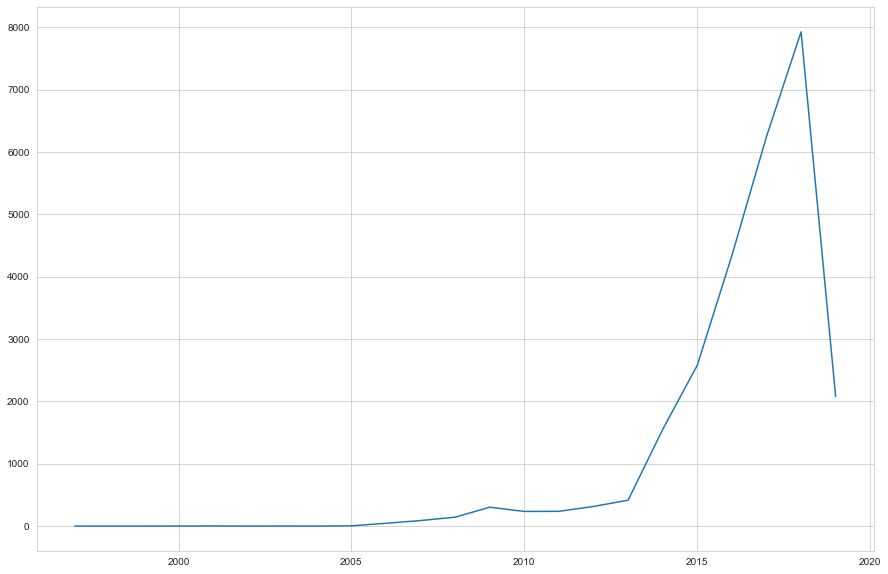

In [39]:
extra_df['release_year'].value_counts()
extra_df['release_year'].value_counts().sort_index().plot(kind='line')

## Ranking values

### Top games based on `owners` and `positive_ratings`

## Comparing groups

### Number of `developers` by `publisher`

In [40]:
main_df.groupby('developer')['name'].nunique().sort_values(ascending=False)

developer
Choice of Games             94
Ripknot Systems             62
Laush Dmitriy Sergeevich    51
Nikita "Ghost_RUS"          50
Dexion Games                45
                            ..
Hinterland Studio Inc.       1
Hio Giang                    1
Hippomancer                  1
Hippopo Entertainment        1
黄昏フロンティア                     1
Name: name, Length: 16769, dtype: int64

## Top rated games per `owners`

# Bivariate analysis

## Correlation heatmap (`owners`, `total_ratings`)

## Correlation between `genre` and `publisher`

# Answering the KBQs

**Outlier treatment proposition.**

Calculate `mean` and `std` per `owners` group and filter out games with low traction based on this statistic per `owners` group.

## As a game developer or publisher

1. What should a company make for their next game?
2. Compare free to play games and paid games in terms of `total_revenue` and `score` 

    Definitions:
    \begin{align}
    \text{total revenue} &= \text{midpoint of owners} \times \text{price}
    \end{align}
    
    \begin{align}
    \text{score} &= \frac{\text{positive ratings}}{\text{total ratings}} \times 100
    \end{align}
    
    Let's use $\geq 80\%$ as high score?
3. What are the kind of paid games with lowest `total_revenue` and `score`?

## Highest rated games by `owners` group

For the casual gamer:
- Get the games with the highest `total_ratings` then highest `score`.

For the connoisseur:
- Get the games with the highest `score` then highest `total_ratings`.

In [41]:
owner_groups = np.sort(main_df['owners'].unique())
owner_groups

array([    35000,     75000,    150000,    350000,    750000,   1500000,
         3500000,   7500000,  15000000,  35000000,  75000000, 150000000])

In [42]:
ratings_by_owners = (main_df.groupby(['owners', 'name'])
                     [['total_ratings', 'score']]
                     .sum()
                     .reset_index(level='name'))

# Indices of h_rated_by_owners are owner groups in descending order
h_rated_by_owners = np.array([ratings_by_owners.loc[idx] 
                              for idx in owner_groups], dtype='object')

ratings_by_owners

,name,total_ratings,score
owners,,,
35000,ARMA: Cold War Assault,4137,77.23
35000,ASTRONEER,33621,84.40
35000,ATLAS,24980,34.51
35000,Age of Mythology: Extended Edition,10913,85.55
35000,AirMech Strike,9080,84.14
...,...,...,...
150000000,侠客风云传前传(Tale of Wuxia:The Pre-Sequel),912,63.27
150000000,拯救大魔王2 Rescue the Great Demon 2,396,75.25
150000000,永遠消失的幻想鄉 ～ The Disappearing of Gensokyo,2417,85.85


In [50]:
# Casual
h_rated_by_owners[2].sort_values(['total_ratings', 'score'], ascending=False)

,name,total_ratings,score
owners,,,
150000,Grand Theft Auto V,468369,70.26
150000,Garry's Mod,380154,95.68
150000,PAYDAY 2,365180,84.52
150000,The Elder Scrolls V: Skyrim,252254,94.07
150000,Z1 Battle Royale,203098,54.87
150000,Paladins®,201987,83.96
150000,Robocraft,111347,72.17
150000,War Thunder,106018,79.09
150000,Heroes & Generals,100272,65.68


In [45]:
# Connoisseur
h_rated_by_owners[4].sort_values(['score', 'total_ratings'], ascending=False)

,name,total_ratings,score
owners,,,
750000,Finding Paradise,6701,98.16
750000,OneShot,11205,98.04
750000,A Hat in Time,14311,97.96
750000,Waltz of the Wizard,1157,97.93
750000,VA-11 Hall-A: Cyberpunk Bartender Action,12642,97.67
...,...,...,...
750000,The District,1387,21.92
750000,GASP,1452,20.18
750000,Command & Conquer 4: Tiberian Twilight,2090,18.09


## Highest rated games by `categories`

## Highest rated games by `genres`

**Revelant genres**
1. Action
2. Casual
3. Adventure                
3. Strategy
4. Simulation              
4. RPG
6. Sports 
7. Racing
8. Massively Multiplayer

In [55]:
#ratings_by_genre = np.array([], dtype='object')
ratings_by_genre = (main_df[main_df['genres'].str.contains('Action')]
                    .groupby(['owners', 'name', 'genres'])
                    [['total_ratings', 'score']]
                    .sum()
                    .reset_index(level=['name', 'genres']))


ratings_by_genre[ratings_by_genre['genres'].str.contains('Action')].loc[35_000]

,name,genres,total_ratings,score
owners,,,,
35000,ARMA: Cold War Assault,Action;Simulation;Strategy,4137,77.23
35000,ATLAS,Action;Adventure;Massively Multiplayer;RPG;Ear...,24980,34.51
35000,AirMech Strike,Action;Free to Play;Indie;Strategy,9080,84.14
35000,Alan Wake's American Nightmare,Action;Adventure,5066,71.02
35000,Alien: Isolation,Action,26492,92.61
...,...,...,...,...
35000,Vindictus,Action;Adventure;Free to Play;Massively Multip...,5106,71.41
35000,Warhammer: End Times - Vermintide,Action;Indie,17465,79.62
35000,We Were Here,Action;Adventure;Free to Play,9239,92.41
